# Complexity Scheduling -- Iterative Cluster Introdution

This project contains an implementation of complexity scheduling for an mnist classifier in the form of iteratively concatenating kmeans clusters of a dataset to the the training set from a starting point of one cluster. 

The order of this notebook is as follows

1.) use kmeans to cluster data, store these clusters for later use

2.) run an iterative process to train data on a single cluster, then concatenate a new cluster into the training set and train again. This is repeated until all clusters have been concatenated.

mnist clf is a simple example that is easily trainable without this method, this notebook is aimed at developing this method for use in more complex datasets for classification. 

In [53]:
#import mnist form tf
from tensorflow import keras
from keras.datasets import mnist
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Separate and Store Clusters

In [48]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0 #normalize the data
x_train = x_train.reshape(len(x_train), -1) #flatten x_train for kmeans

print(f'X_train shape: {x_train.shape} \nX_test shape: {x_test.shape} \nY_train shape: {y_train.shape}\nY_test shape: {y_test.shape}')

X_train shape: (60000, 784) 
X_test shape: (10000, 28, 28) 
Y_train shape: (60000,)
Y_test shape: (10000,)


Below we cluster the data into 10 clusters (one for each digit), reshape the flattened examples -> (28, 28), and store in the list 'clusters'.

In [49]:
cluster = {}
kmeans = KMeans(n_clusters=10, random_state=42).fit(x_train)
pred_cluster = kmeans.predict(x_train) #predict cluster for each data point
print(f'Predicted cluster shape: {pred_cluster.shape}')

for i in range(10):
    cluster[i] = [  x_train[np.where(pred_cluster == i)], y_train[np.where(pred_cluster == i)]  ]#assign [cluster i, associated labels] list to cluster[i]
    cluster[i][0] = cluster[i][0].reshape(len(cluster[i][0]), 28, 28) #rehape cluster features back to shape (batch, 28, 28)
    print(f'Cluster {i} shape: {cluster[i][0].shape}')

C:\Users\hunte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Predicted cluster shape: (60000,)
Cluster 0 shape: (5642, 28, 28)
Cluster 1 shape: (4669, 28, 28)
Cluster 2 shape: (5959, 28, 28)
Cluster 3 shape: (6518, 28, 28)
Cluster 4 shape: (3096, 28, 28)
Cluster 5 shape: (8842, 28, 28)
Cluster 6 shape: (7434, 28, 28)
Cluster 7 shape: (3202, 28, 28)
Cluster 8 shape: (8919, 28, 28)
Cluster 9 shape: (5719, 28, 28)


An interesting thing to note is that the data has not been clustered solely by label. Each cluster contains examples from every class. When we train our model on these clusters one at a time, the idea is that it will learn specific features of the way people write their digits each way at a time. Therefore, building upon priot knowledge, in a sense.

In [50]:
#print unique values each clutser's labels
for i in range(10):
    print(f'Cluster {i} unique labels: {np.unique(cluster[i][1])}')

Cluster 0 unique labels: [0 1 2 3 4 5 6 7 8 9]
Cluster 1 unique labels: [0 1 2 3 4 5 6 7 8 9]
Cluster 2 unique labels: [0 1 2 3 4 5 6 7 8 9]
Cluster 3 unique labels: [0 1 2 3 4 5 6 7 8 9]
Cluster 4 unique labels: [0 2 3 4 5 6 7 8 9]
Cluster 5 unique labels: [0 1 2 3 4 5 6 7 8 9]
Cluster 6 unique labels: [0 1 2 3 4 5 6 7 8 9]
Cluster 7 unique labels: [0 2 3 4 5 6 7 8 9]
Cluster 8 unique labels: [0 1 2 3 4 5 6 7 8 9]
Cluster 9 unique labels: [0 1 2 3 4 5 6 7 8 9]


We will define a simple feed forward net for our mnist clf.

In [57]:
#buld simple mnist clf
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Cluster Scheduling

Next, we'll construct the mechanism to train the data on the first cluster, then concatenate the next cluster into the training set and train again. 

Remember, our clusters are stored in the list cluster, each element of cluster is a two element list [cluster_data, cluster_labels]. 

In [58]:
def cluster_scheduling():
    X, y = cluster[0][0], cluster[0][1] #get first cluster's data
    historical_scores = []

    for i in range(10):
        # resplit data into train and validation
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        print(f'Data Shape for {i+1} Cluster(s):\nX_train shape: {X_train.shape}'), print(f'y_train shape: {y_train.shape}'), print(f'X_val shape: {X_val.shape}'), print(f'y_val shape: {y_val.shape}\n')

        model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=10)], verbose=0) #train model on current subset of data
        if i != 9: 
            X = np.concatenate((X_train, cluster[i+1][0]), axis=0)#if not last cluster, concatenate next cluster's data to current data
            y = np.concatenate((y_train, cluster[i+1][1]), axis=0)
    
        historical_scores.append(model.evaluate(X_val, y_val, verbose=0)[1]) #append current score to historical scores
        print(f'Score after {i+1} subsets of training data: {historical_scores[i]}\n') # evaluate on current subset of validation data

    #fine tuning with lower lr with all clusters 
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy']) #recompile with lower lr
    model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=10)], verbose=0)
    print(f'\nScore after fine tuning: {model.evaluate(X_val, y_val, verbose=0)}\n')
    return model, historical_scores

model, historical_scores = cluster_scheduling()

Data Shape for 1 Cluster(s):
X_train shape: (4513, 28, 28)
y_train shape: (4513,)
X_val shape: (1129, 28, 28)
y_val shape: (1129,)

Score after 1 subsets of training data: 0.9592559933662415

Data Shape for 2 Cluster(s):
X_train shape: (7345, 28, 28)
y_train shape: (7345,)
X_val shape: (1837, 28, 28)
y_val shape: (1837,)

Score after 2 subsets of training data: 0.9847577810287476

Data Shape for 3 Cluster(s):
X_train shape: (10643, 28, 28)
y_train shape: (10643,)
X_val shape: (2661, 28, 28)
y_val shape: (2661,)

Score after 3 subsets of training data: 0.9830890893936157

Data Shape for 4 Cluster(s):
X_train shape: (13728, 28, 28)
y_train shape: (13728,)
X_val shape: (3433, 28, 28)
y_val shape: (3433,)

Score after 4 subsets of training data: 0.9898048639297485

Data Shape for 5 Cluster(s):
X_train shape: (13459, 28, 28)
y_train shape: (13459,)
X_val shape: (3365, 28, 28)
y_val shape: (3365,)

Score after 5 subsets of training data: 0.9946508407592773

Data Shape for 6 Cluster(s):
X_tra

Here is a plot of the scores the model achieved at each cluster of trianing.

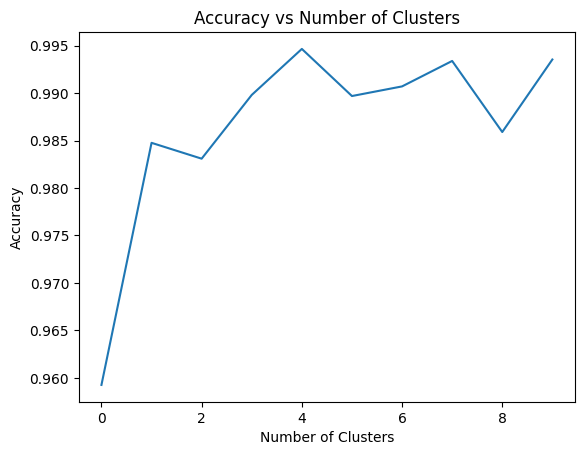

In [59]:
#create plot for historical scores
plt.plot(historical_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Clusters')
plt.show()

# Comparision to Traditional Training

Below is comparision to the same model trained without complexity scheduling. It achieved only 94.73% accuracy as opposed to 99.39% with complexity scheduling.

Overall, this method is highly effective for increasing accuracy of a model without changing the models architecutre. I will be adding this method to my toolbox for future projects. Soon, I will combine this method with the model architecture scheduling that was experimented in the previous notebook in this directory.

In [41]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#buld simple mnist clf
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[EarlyStopping(patience=10)], verbose=0)

print(f'Score on all data: {model.evaluate(x_test, y_test, verbose=2)}\n')

313/313 - 0s - loss: 0.3421 - accuracy: 0.9473 - 271ms/epoch - 866us/step
Score on all data: [0.3420996069908142, 0.9473000168800354]

